# MNIST dataset with convolutional autoencoders

This notebook contains the analysis of the MNIST dataset with convolutional autoencoders. The workflow is as follows
1. Import data and prepare it to enter PyTorch models.
2. Setup the autoencoder model and see how well it reproduces the encoded images. 
3. Detach the encoder part and attach to it a classifier head. Train it to classify the numbers.
4. Repeat the process with another Autoencoder achitecture. The goal is to reduce the number of encoder output nodes.

This notebook contains the analysis 3 neural network architectures:
* `model_0`: Model architecture taken from https://youtu.be/zp8clK9yCro?si=gLD7SKyjN6pMwdT7 : ConvNet with 64 latent representation neurons
* `model_1`: Model with 8 latent representation neurons. Compression is achieved by setting the `stride` parameter
* `model_1`: Model with 16 latent representation neurons. Compression is achieved by setting the `stride` parameter.

Each model class contains the following subnetworks
* `model.encoder` - encoder part of neural network. Its output is the latent representation
* `model.decoder` - decoder part of neural network. Its input is the latent representation and output is the reconstructed image.
* `model.classifier` - classifier head. Its input is the latent representation and output is the predicted label - number in the image.

The models are trained according to the following procedure:
1. Train the `model.encoder` and `model.decoder` to reconstruct the images. `model.classifier` head is frozen during the training.
2. Freeze the layers in `model.encoder` and `model.decoder`. Unfreeze `model.classifier` and train it to predict image labels based on latent representation.

Some functionalities are coded in external files:
* `engine.py` contains the training functionalities
* `model_classes.py` contains the classes with neural network architectures
* `utils.py` contains the utility functions

The notebook can either load pretrained modules or train the models from scratch. Use the cell below to mark which option you prefer:

In [1]:
### Select mode from options "load_model" and "train_model"
#MODE = "train_model"
MODE = "load_model"

### Define number of epochs used to train every model
EPOCHS = 10

## 1. Data preparation.

In this section, we download the data and prepare it to enter a PyTorch model.

In [2]:
import torch 
from torch import nn
from torchvision import datasets, transforms
from torchinfo import summary

import matplotlib.pyplot as plt
from pathlib import Path
import random

import engine, utils, model_classes

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device =}")

device ='cpu'


In [4]:
# Setup the transform for the images
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root = "data",
                              train = True,
                              download = True,
                              transform = transform,
                              target_transform=None)
test_dataset = datasets.MNIST(root = "data",
                              train = False,
                              download = True,
                              transform = transform,
                              target_transform=None)
print(f"Length of train dataset = {len(train_dataset)}")
print(f"Length of test dataset = {len(test_dataset)}")

# Setup DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = True
)
print(f"[INFO] DataLoaders prepared.")

Length of train dataset = 60000
Length of test dataset = 10000
[INFO] DataLoaders prepared.


**Show example images**

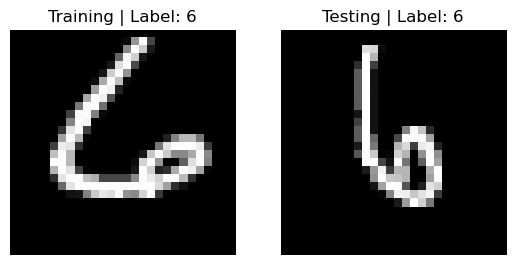

In [5]:
# Get images to plot
images, labels = next(iter(train_dataloader))
train_image, train_label = images[17], labels[17]
images, labels = next(iter(test_dataloader))
test_image, test_label = images[17], labels[17]

# Plot images
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_image.squeeze(), cmap="gray")
ax1.set_title(f"Training | Label: {train_label}")
ax1.set_axis_off()
ax2.imshow(test_image.squeeze(), cmap="gray")
ax2.set_title(f"Testing | Label: {test_label}")
ax2.set_axis_off()

## 2. Setup autoencoder model and observe reproduced images

We will perform the full training workflow for the network from https://youtu.be/zp8clK9yCro?si=gLD7SKyjN6pMwdT7

### 2.1. Setup the model class and instantiate the model

Let's setup the model and analyze the shape of the image during the forward pass

In [6]:
# Instantiate the model
model_0 = model_classes.CNN_Autoencoder().to(device)

In [7]:
print(f"Initial image shape: {train_image.shape}")
# Dummy forward pass - encoder
encoder_output = model_0(train_image, mode = "encoder")
print(f"Encoder output shape: {encoder_output.shape}")
# Dummy forward pass - autoencoder
autoencoder_output = model_0(train_image, mode = "autoencoder")
print(f"Encoder output shape: {autoencoder_output.shape}")
# Classifier output: 
classifier_output = model_0(train_image.unsqueeze(dim=0), mode = "classifier") # Unsqueeze to add batch dimension
print(f"Classifier output shape: {classifier_output.shape}")

Initial image shape: torch.Size([1, 28, 28])
Encoder output shape: torch.Size([64, 1, 1])
Encoder output shape: torch.Size([1, 28, 28])
Classifier output shape: torch.Size([1, 10])


### 2.2. Perform training and testing loops or load model.

Training and testing loops instantiated in `engine.py`.

In [8]:
# Data used to load/save the model
MODEL_PATH = Path("trained_models")
MODEL_NAME = "CNN_Autoencoder.pth"

if MODE == "train_model":
    # Train model
    model_0_results = engine.train_autoencoder(
        model = model_0, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)
    
    # Save dictionary with loss curves
    utils.save_dict(model_0_results, "model_result_dictionaries", "model_0_results.pkl")
    
elif MODE == "load_model":
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
    
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_0_results.pkl"
    model_0_results = utils.load_dict(path/name)

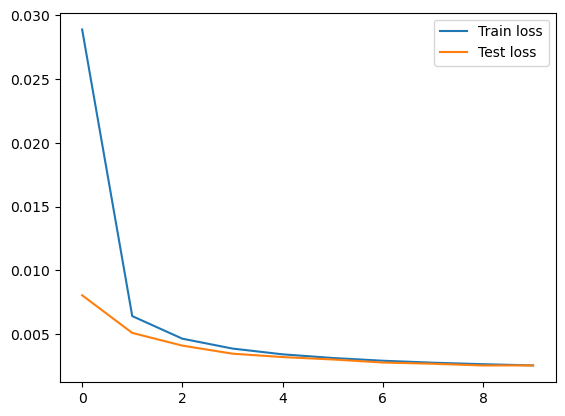

In [9]:
# Plot loss curves
plt.plot(model_0_results["train_loss"], label = "Train loss")
plt.plot(model_0_results["test_loss"], label = "Test loss")
plt.legend()

### 2.3. Plot random reconstruction.

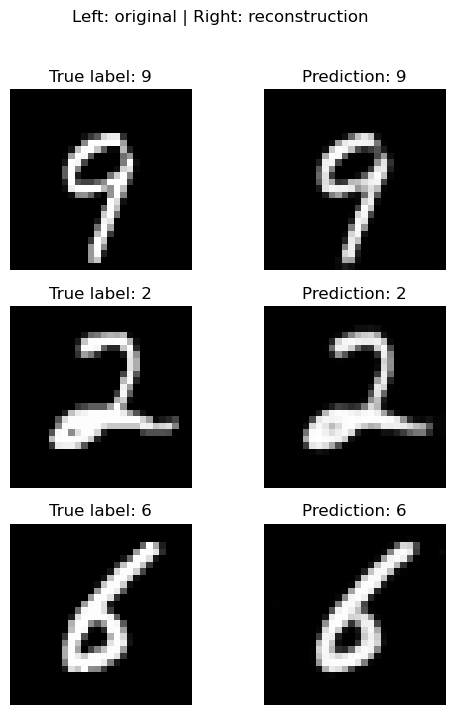

In [10]:
utils.plot_reconstructions(model = model_0, dataset = test_dataset)

## 3. Classifier training

### 3.1. Prepare the model for training

We must
* freeze the `encoder` and `decoder` parameters
* unfreeze the `classifier` parameters and make them trainable

**Note**: The classifier head is trained only if the `MODE` option is selected to `"train_model"`

In [11]:
if MODE == "train_model":
    # Train model
    model_0_classifier_results = engine.train_classifier(
        model = model_0, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)
    
    # Save dictionary with loss curves
    utils.save_dict(model_0_classifier_results, "model_result_dictionaries", "model_0_classifier_results.pkl")
    
elif MODE == "load_model":
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_0_classifier_results.pkl"
    model_0_classifier_results = utils.load_dict(path/name)

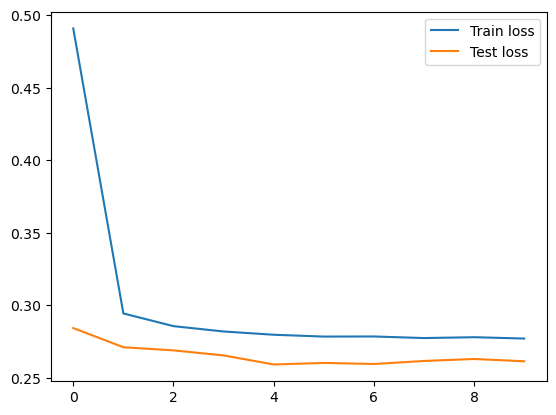

In [12]:
# Plot loss curves
plt.plot(model_0_classifier_results["train_loss"], label = "Train loss")
plt.plot(model_0_classifier_results["test_loss"], label = "Test loss")
plt.legend()

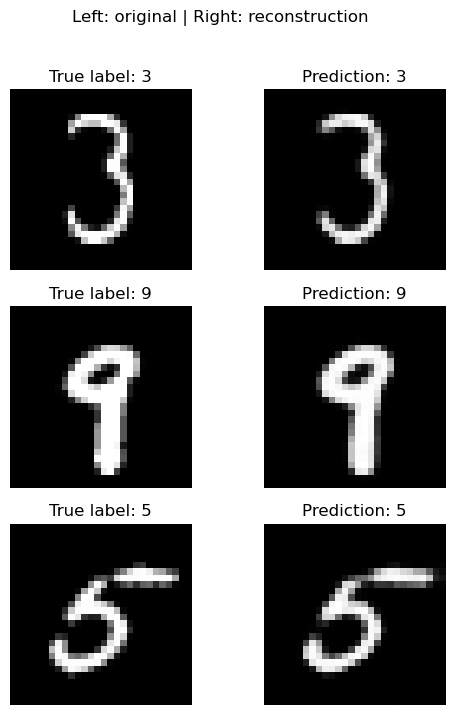

In [13]:
# Plot reconstructions
utils.plot_reconstructions(model = model_0, dataset = test_dataset)

This is likely to be the best performing model in this notebook, as it has most neurons in the latent representation. The encoder compresses the image from $28\cdot28=784$ pixels to **64 numbers**. We will try to construct a different model with smaller number of neurons in latent representation.  

### 4. Autoencoder architecture with small number of output neurons.

We will repeat the workflow from previous section with another autoencoder architecture. The architecture is defined in `CNN_Tiny_Autoencoder` class in `model_classes.py`. It has **8 perceptrons** in latent representation.

In [14]:
# Setup the model
model_1 = model_classes.CNN_Tiny_Autoencoder().to(device)
    
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [15]:
print(f"Initial image shape: {train_image.shape}")
unsqueezed_image = train_image.unsqueeze(dim=0)
print(f"Unsqueezed initial image shape: {unsqueezed_image.shape}")
# Dummy forward pass - encoder
encoder_output = model_1(unsqueezed_image, mode = "encoder")
print(f"Encoder output shape: {encoder_output.shape}")
# Dummy forward pass - autoencoder
autoencoder_output = model_1(unsqueezed_image, mode = "autoencoder")
print(f"Encoder output shape: {autoencoder_output.shape}")
# Classifier output: 
classifier_output = model_0(train_image.unsqueeze(dim=0), mode = "classifier") # Unsqueeze to add batch dimension
print(f"Classifier output shape: {classifier_output.shape}")

Initial image shape: torch.Size([1, 28, 28])
Unsqueezed initial image shape: torch.Size([1, 1, 28, 28])
Encoder output shape: torch.Size([1, 8, 1, 1])
Encoder output shape: torch.Size([1, 1, 28, 28])
Classifier output shape: torch.Size([1, 10])


In [16]:
# Data used to load/save the model
MODEL_PATH = Path("trained_models")
MODEL_NAME = "CNN_Tiny_Autoencoder.pth"

if MODE == "train_model":
    # Train model
    model_1_results = engine.train_autoencoder(
        model = model_1, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)

    # Save dictionary with loss curves
    utils.save_dict(model_1_results, "model_result_dictionaries", "model_1_results.pkl")
    
elif MODE == "load_model":
    # Load model
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
    
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_1_results.pkl"
    model_1_results = utils.load_dict(path/name)

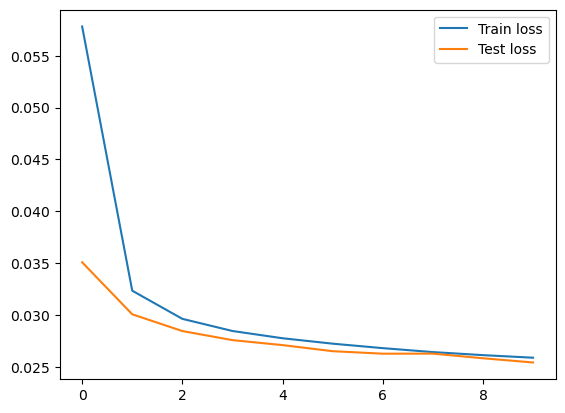

In [17]:
# Plot loss curves
plt.plot(model_1_results["train_loss"], label = "Train loss")
plt.plot(model_1_results["test_loss"], label = "Test loss")
plt.legend()

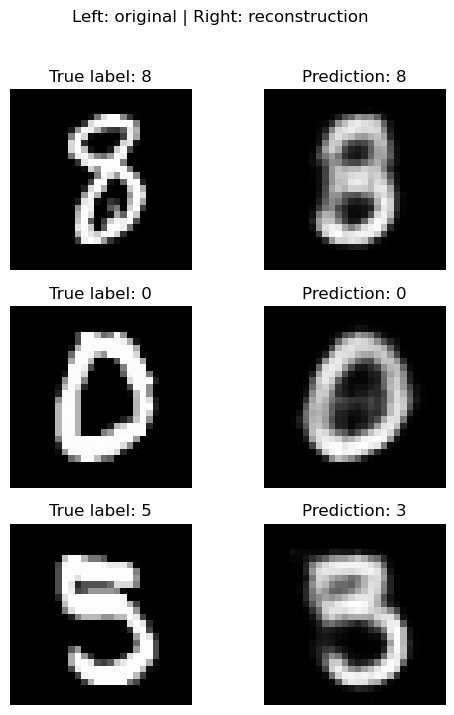

In [18]:
utils.plot_reconstructions(model = model_1, dataset = test_dataset)

**Train classifier**

In [19]:
if MODE == "train_model":
    # Train model
    model_1_classifier_results = engine.train_classifier(
        model = model_1, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)
    
    # Save dictionary with loss curves
    utils.save_dict(model_1_classifier_results, "model_result_dictionaries", "model_1_classifier_results.pkl")
    
elif MODE == "load_model":
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_1_classifier_results.pkl"
    model_1_classifier_results = utils.load_dict(path/name)

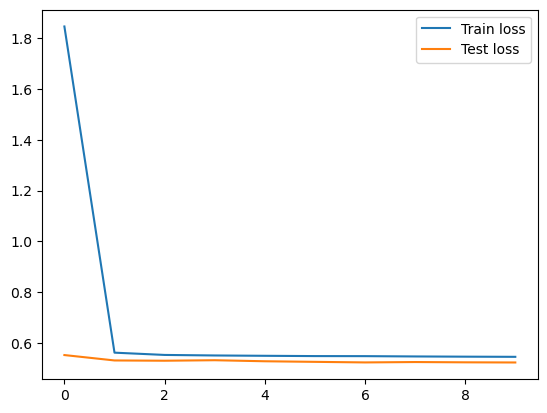

In [20]:
# Plot loss curves
plt.plot(model_1_classifier_results["train_loss"], label = "Train loss")
plt.plot(model_1_classifier_results["test_loss"], label = "Test loss")
plt.legend()

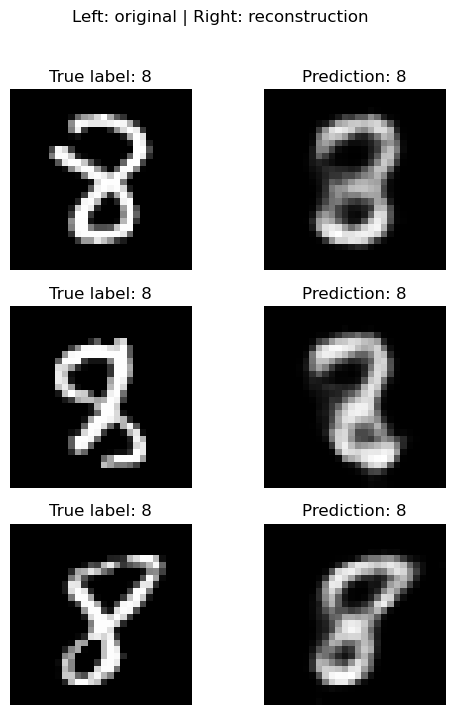

In [21]:
utils.plot_reconstructions(model = model_1, dataset = test_dataset)

This is likely to be the worst performing model in this notebook. However, given that the input image is compressed to just **8 numbers**, it is actually not that bad.

## 5. Autoencoder architecture with 16 perceptrons in latent representation.

In [22]:
model_2 = model_classes.CNN_Medium_Autoencoder()

In [23]:
print(f"Initial image shape: {train_image.shape}")
unsqueezed_image = train_image.unsqueeze(dim=0)
print(f"Unsqueezed initial image shape: {unsqueezed_image.shape}")
# Dummy forward pass - encoder
encoder_output = model_2(unsqueezed_image, mode = "encoder")
print(f"Encoder output shape: {encoder_output.shape}")
print(f"Number of elements: {encoder_output.numel()}")
# Dummy forward pass - autoencoder
autoencoder_output = model_2(unsqueezed_image, mode = "autoencoder")
print(f"Encoder output shape: {autoencoder_output.shape}")
# Classifier output: 
classifier_output = model_0(train_image.unsqueeze(dim=0), mode = "classifier") # Unsqueeze to add batch dimension
print(f"Classifier output shape: {classifier_output.shape}")

Initial image shape: torch.Size([1, 28, 28])
Unsqueezed initial image shape: torch.Size([1, 1, 28, 28])
Encoder output shape: torch.Size([1, 16, 1, 1])
Number of elements: 16
Encoder output shape: torch.Size([1, 1, 28, 28])
Classifier output shape: torch.Size([1, 10])


In [24]:
# Data used to load/save the model
MODEL_PATH = Path("trained_models")
MODEL_NAME = "CNN_Medium_Autoencoder.pth"

if MODE == "train_model":
    # Train model
    model_2_results = engine.train_autoencoder(
        model = model_2, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)

    # Save dictionary with loss curves
    utils.save_dict(model_2_results, "model_result_dictionaries", "model_2_results.pkl")
    
elif MODE == "load_model":
    # Load model
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
    
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_2_results.pkl"
    model_2_results = utils.load_dict(path/name)

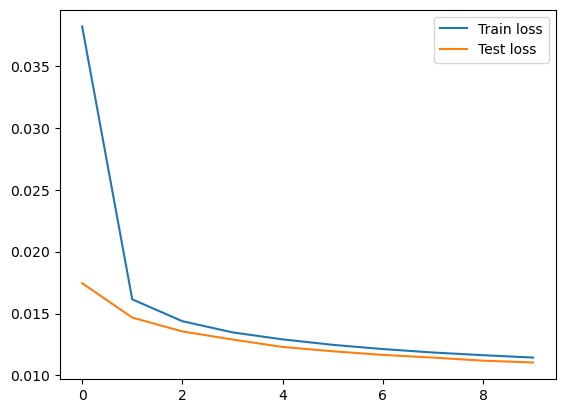

In [25]:
# Plot loss curves
plt.plot(model_2_results["train_loss"], label = "Train loss")
plt.plot(model_2_results["test_loss"], label = "Test loss")
plt.legend()

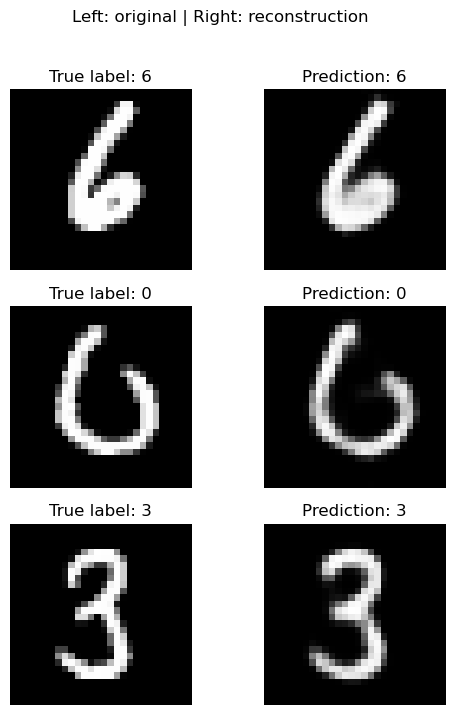

In [26]:
utils.plot_reconstructions(model = model_2, dataset = test_dataset)

**Train classifier**

In [27]:
if MODE == "train_model":
    # Train model
    model_2_classifier_results = engine.train_classifier(
        model = model_2, 
        train_dataloader = train_dataloader, 
        test_dataloader = test_dataloader,
        epochs = EPOCHS,
        device = device,
        save_path = MODEL_PATH ,
        save_file_name = MODEL_NAME)
    
    # Save dictionary with loss curves
    utils.save_dict(model_2_classifier_results, "model_result_dictionaries", "model_2_classifier_results.pkl")
    
elif MODE == "load_model":
    # Load loss dict
    path, name = Path("model_result_dictionaries"), "model_2_classifier_results.pkl"
    model_2_classifier_results = utils.load_dict(path/name)

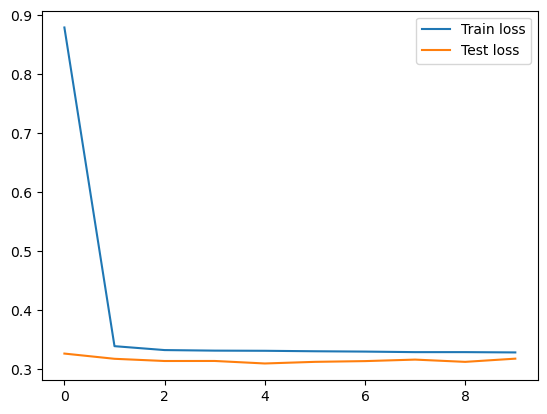

In [28]:
# Plot loss curves
plt.plot(model_2_classifier_results["train_loss"], label = "Train loss")
plt.plot(model_2_classifier_results["test_loss"], label = "Test loss")
plt.legend()

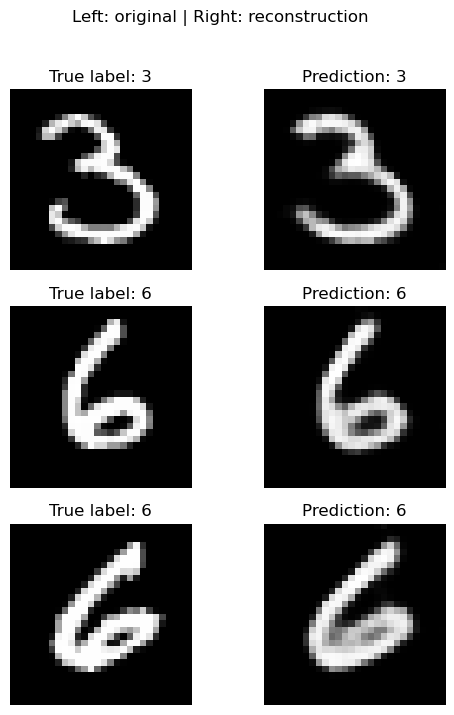

In [29]:
utils.plot_reconstructions(model = model_2, dataset = test_dataset)

## 6. Compare results of different architectures.

We will compare the following
1. Train and test loss curves for autoencoder and classifier training.
2. Autoencoder reconstructions and predictions.
3. Confusion matrices.

### 6.1. Comparison of loss curves.

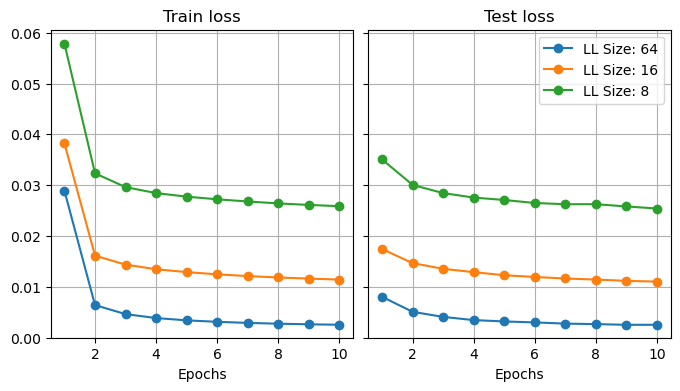

In [30]:
model_results = [model_0_results, model_2_results, model_1_results]
model_names = ["LL Size: 64",
               "LL Size: 16",
               "LL Size: 8"]
utils.plot_loss_curves(model_results, model_names)

The `LL Size` in the plots denotes the size of latent representation, i.e., the number of perceptrons in latent representation. We expect the loss values to be lower with increased `LL Size`.

### 6.2. Compare model reconstructions.

This section contains the comparison of reconstructions and predictions for each model.
Run the cell below to perform the procedure for 5 random images.

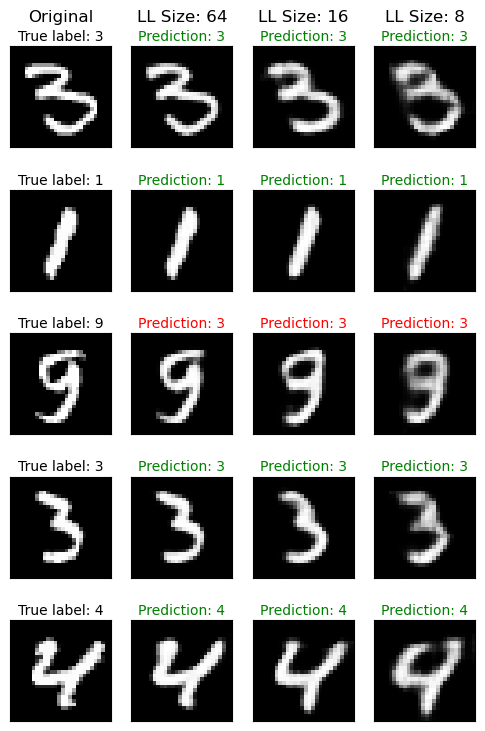

In [43]:
model_list = [model_0, model_2, model_1]
utils.plot_many_reconstructions(model_list, test_dataset, model_names)

### 6.3. Compute confusion matrices.

This section contains the confusion matrices for each model.

Model: `model_0`
* 64 perceptrons in latent representation

Model accuracy: 0.92


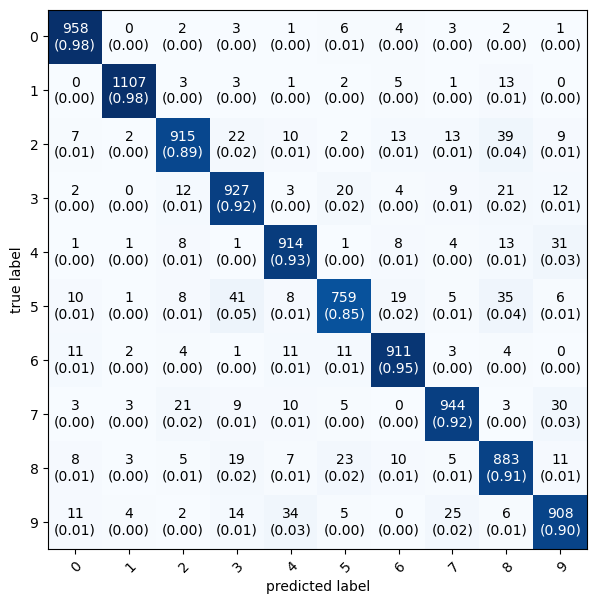

In [32]:
acc_0 = utils.compute_confusion_matrix(model_0, test_dataset, device = device)
print(f"Model accuracy: {acc_0:.2f}")

Model: `model_2`
* 16 perceptrons in latent representation

Model accuracy: 0.91


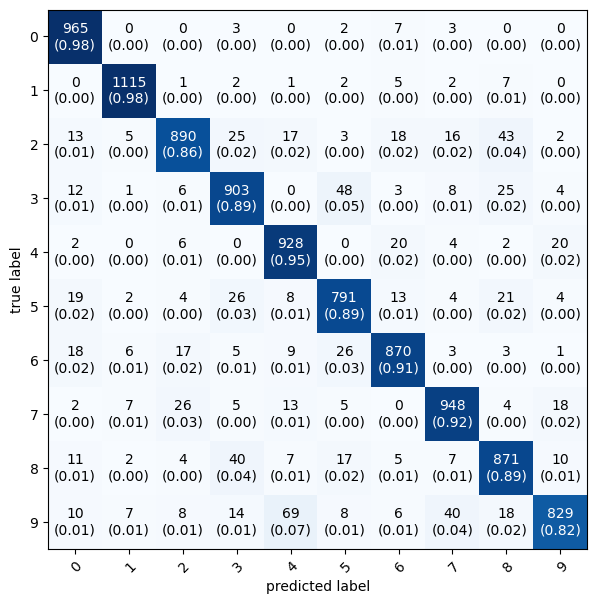

In [33]:
acc_2 = utils.compute_confusion_matrix(model_2, test_dataset, device = device)
print(f"Model accuracy: {acc_2:.2f}")

Model: `model_1`
* 8 perceptrons in latent representation

Model accuracy: 0.84


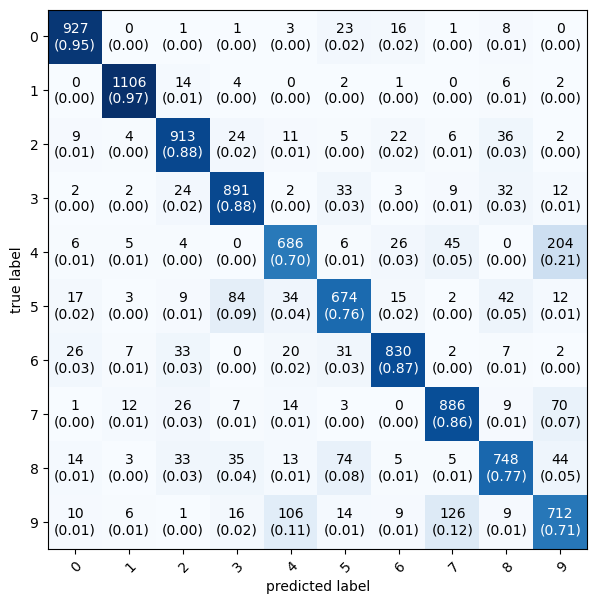

In [34]:
acc_1 = utils.compute_confusion_matrix(model_1, test_dataset, device = device)
print(f"Model accuracy: {acc_1:.2f}")